# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---
In this notebook we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output:

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Each imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure to download the required human and dog datasets:



* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


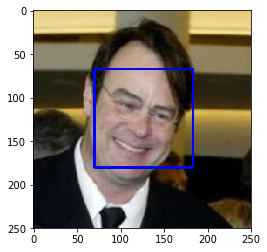

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

With the OpenCV implementation and the face_detector function we achieved the following results:
> 97% of human faces detected in human_files_short (97% accuracy)

> 17% of human faces detected in dog_files_short (83% accuracy)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_faces_in_humans = 0
human_faces_in_dogs = 0


for img in range(1, len(human_files_short)):
    if face_detector(human_files_short[img]):
        human_faces_in_humans += 1

    if face_detector(dog_files_short[img]):
        human_faces_in_dogs += 1
            

print('The percentage of human faces detected in human_files_short: {}%'.format(human_faces_in_humans))
print('Percentage of human faces detected in dog_files_short: {}%'.format(human_faces_in_dogs))

The percentage of human faces detected in human_files_short: 97%
Percentage of human faces detected in dog_files_short: 17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Next we used the code cell below to design and test our own face detection algorithm.

In [5]:
### (Optional) 
### Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

# returns "True" if face is detected in image stored at img_path
def face_detector_2(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,scaleFactor=1.05)
    return len(faces) > 0

> I will try to use the OpenCV again but add a scaling parameter to check how the size of the image impacts the accuracy of the detection.

In [6]:
human_faces_in_humans_2 = 0
human_faces_in_dogs_2 = 0


for img in range(1, len(human_files_short)):
    if face_detector_2(human_files_short[img]):
        human_faces_in_humans_2 += 1

    if face_detector_2(dog_files_short[img]):
        human_faces_in_dogs_2 += 1
            

print('The percentage of human faces detected in human_files_short: {}%'.format(human_faces_in_humans_2))
print('Percentage of human faces detected in dog_files_short: {}%'.format(human_faces_in_dogs_2))

The percentage of human faces detected in human_files_short: 99%
Percentage of human faces detected in dog_files_short: 32%


> So I verified that by reducing the image size by 5% the accuracy of our detection algorithm increased by 2 p.p in the presence of human images. This probably happened beacuse by resizing the image to a smaller one, some faces become more detectable for the algorithm.

> However, it made a greater number of errors in the presence of dog images, incorrectly classifying 32% of the images (instead of the previous 17%).

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 63757696.54it/s] 


In [8]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
print(VGG16.classifier[6].in_features) 
print(VGG16.classifier[6].out_features)

4096
1000


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
from PIL import Image
import torchvision.transforms as transforms


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Open image
    img = Image.open(img_path)
    
    plt.imshow(np.asarray(img))
    
    # Tranform data to a normalized torch.FloatTensor
    transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    
    img_transform = transform(img).unsqueeze_(0).float()
    
    # move tensor to GPU if CUDA is available
    if torch.cuda.is_available():
        class_index = VGG16(img_transform.cuda()) 
    else:
        class_index = VGG16(img_transform)
    
    # Output the class index with largest value
    predicted_class_index = class_index.data.cpu().numpy().argmax()
    
    return predicted_class_index # predicted class index

236

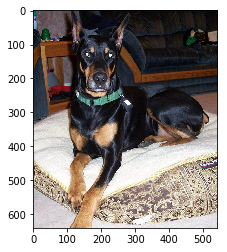

In [11]:
VGG16_predict(dog_files_short[92])

In [12]:
import urllib
import pickle

# Create a function that returns the class label
def labels(class_index):    
    '''
This function returns the class for a given class index

Args: 
  class_index - an integer between 0 and 999, inclusive

Returns:
  class_label - string
    '''
    url_labels = "https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl"
    labels_dict = pickle.load(urllib.request.urlopen(url_labels))

    return labels_dict[class_index]

208
Labrador retriever


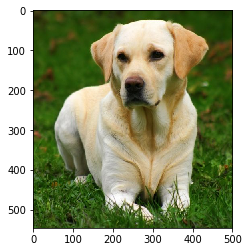

In [13]:
# Test classes function
img_path = "images/Labrador_retriever_06457.jpg"
predicted_index = VGG16_predict(img_path)
predicted_label = labels(predicted_index)

print(predicted_index)
print(predicted_label)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we noticed that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    return (151 <= VGG16_predict(img_path) <=268)

True

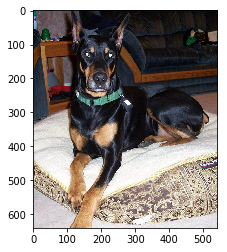

In [15]:
dog_detector(dog_files_short[92])

True

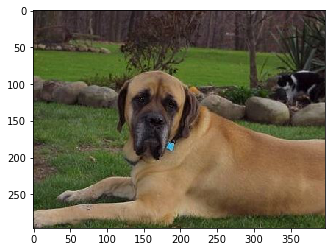

In [16]:
dog_detector(dog_files_short[55])

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__  Test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

With the VGG16 network and the dog_detector function we achieved the following results:
> 0% of dogs detected in human_files_short (100% accuracy)

> 99% of dogs detected in dog_files_short (99% accuracy)


The percentage of dogs detected in human_files_short: 1%
Percentage of dogs detected in dog_files_short: 98%


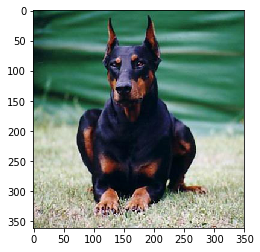

In [17]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_faces_in_humans = 0
dog_faces_in_dogs = 0


for img in range(1, len(human_files_short)):
    if dog_detector(human_files_short[img]):
        dog_faces_in_humans += 1

    if dog_detector(dog_files_short[img]):
        dog_faces_in_dogs += 1
            

print('The percentage of dogs detected in human_files_short: {}%'.format(dog_faces_in_humans))
print('Percentage of dogs detected in dog_files_short: {}%'.format(dog_faces_in_dogs))

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We will create a CNN _from scratch_ (so, we can't use transfer learning _yet_!), and we must attain a test accuracy of at least 10%.  In Step 4 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

We used the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [18]:
import os
from torchvision import datasets

###  Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Define training, validation and test data directiories
data_dir = '/data/dog_images/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

In [19]:
## Load and transform data using ImageFolder

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])


# Transform data
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

# Print out number of images in each dataset
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num validation images:  835
Num test images:  836


In [20]:
# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

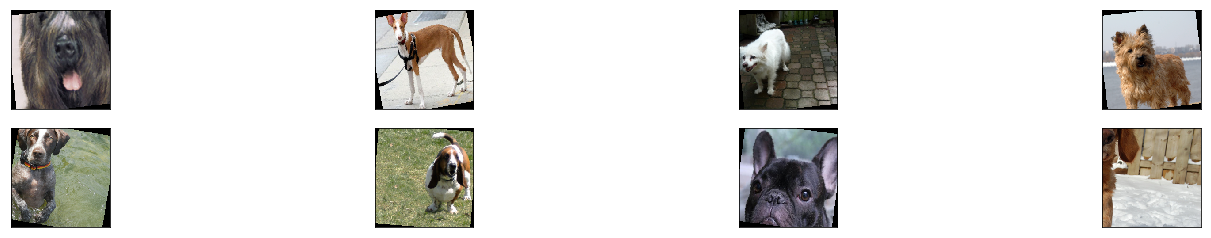

In [21]:
## Visualize a batch of training data
    
def imshow(img):
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img=unnormalize(img)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, label = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(labels(int(label[idx])))

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
* First all images were resized and crop to 224x224 images, using RandomResizedCrop(). I chose this size anticipating that networks like VGG16 expect 224-dim square images as input.


* Yes, I applied some augmentation transformations to the dataset as they will help to avoid overfitting. By showing new images to the model, it should be better at generalizing. The goal was to turn the model rotation and scale invariant, so first I applied a RandomHorizontalFlip() transformation - that randomly flips an image along its horizontal axis - and then applied a RandomRotation(10) - that randomly rotates an image by 10 degrees.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [22]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
         # 1st convolutional layer 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # 2nd convolutional layer 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # 3rd convolutional layer 
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        
        # linear layer (500 -> 133)
        self.fc2 = nn.Linear(500, 133)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

Some considerations about my final CNN architecture:
* I've defined the input layer of the CNN with a shape of 224x224x3, which correspond to the size of each image times the depth of the RGB filters.


* I've started by defining a sequence 3 convolutional layers and 3 pooling layers. Each convolutional layer increased the depth/feature maps of the input tensor, while each pooling layer reduce the size/dimension of the tensors to half. The downsampling method I applied was MaxPooling2D with a kernel size and a stride of 2. In fact I based my decision on the literature suggested in the classroom exercises and I verified that this architecture is very used in problems of this kind, while offering relatively simple computational processing.


* Finally I added 2 fully connected layer that produced an output of 133 classes, which represen the dog breeds. Between each FC layer I've added a dropout layer with p = 0.2 in order to avoid overfitting. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [23]:
import torch.optim as optim

### Select loss function
criterion_scratch = nn.CrossEntropyLoss()

### Select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [24]:
image_datasets = {'train':train_data,
                  'valid':valid_data,
                  'test':test_data
                 }
loaders_scratch = {'train':train_loader,
                   'valid':valid_loader,
                   'test':test_loader
                  }

In [25]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # update training loss
            train_loss += loss.item()*data.size(0)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), save_path)
        valid_loss_min = valid_loss
            
    # return trained model
    return model


In [26]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.873126 	Validation Loss: 4.834318
Validation loss decreased (inf --> 4.834318).  Saving model ...
Epoch: 2 	Training Loss: 4.802425 	Validation Loss: 4.759542
Validation loss decreased (4.834318 --> 4.759542).  Saving model ...
Epoch: 3 	Training Loss: 4.759036 	Validation Loss: 4.726424
Validation loss decreased (4.759542 --> 4.726424).  Saving model ...
Epoch: 4 	Training Loss: 4.681410 	Validation Loss: 4.652022
Validation loss decreased (4.726424 --> 4.652022).  Saving model ...
Epoch: 5 	Training Loss: 4.587144 	Validation Loss: 4.603799
Validation loss decreased (4.652022 --> 4.603799).  Saving model ...
Epoch: 6 	Training Loss: 4.549074 	Validation Loss: 4.553211
Validation loss decreased (4.603799 --> 4.553211).  Saving model ...
Epoch: 7 	Training Loss: 4.516539 	Validation Loss: 4.552531
Validation loss decreased (4.553211 --> 4.552531).  Saving model ...
Epoch: 8 	Training Loss: 4.486095 	Validation Loss: 4.498462
Validation loss decreased (4.55253

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [27]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        
        total += data.size(0)
        

            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [28]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.995695


Test Accuracy: 10% (91/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  Our CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

We used the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [29]:
## Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [30]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

print(model_transfer)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Add a last linear layer  that maps n_inputs -> 133 dog breed classes
n_inputs = model_transfer.classifier[6].in_features
n_outputs = 133

last_layer = nn.Linear(n_inputs, n_outputs)
model_transfer.classifier[6] = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

# Check to see if the last layer produced the expected number of outputs
print(model_transfer.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

On the tranfer learning problem I took the previous classroom exercises as a reference and thus, I chose to use the VGG16 Network to create this final CNN architecture. 
I also took some time to read about the VGG16 and some of its applications on real world examples, and it seemed to be a very robust architecture. 

So, as VGG16 was previously trained on the ImageNet dataset and its weights were already fine-tuned to image recognition and feature extraction, I started by freezing the backpropagation of all feature layers. 

Then I just had to modify the last layer (the fully connected layer) to produced my desired output, which are the 133 dog breed classes. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

We used the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [31]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [32]:
# train the model
n_epochs = 30

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.281307 	Validation Loss: 1.178381
Validation loss decreased (inf --> 1.178381).  Saving model ...
Epoch: 2 	Training Loss: 1.366564 	Validation Loss: 1.015274
Validation loss decreased (1.178381 --> 1.015274).  Saving model ...
Epoch: 3 	Training Loss: 1.211149 	Validation Loss: 0.979475
Validation loss decreased (1.015274 --> 0.979475).  Saving model ...
Epoch: 4 	Training Loss: 1.117879 	Validation Loss: 0.949046
Validation loss decreased (0.979475 --> 0.949046).  Saving model ...
Epoch: 5 	Training Loss: 1.081227 	Validation Loss: 0.955968
Epoch: 6 	Training Loss: 1.064396 	Validation Loss: 0.922309
Validation loss decreased (0.955968 --> 0.922309).  Saving model ...
Epoch: 7 	Training Loss: 0.991656 	Validation Loss: 0.926919
Epoch: 8 	Training Loss: 0.961667 	Validation Loss: 0.848550
Validation loss decreased (0.926919 --> 0.848550).  Saving model ...
Epoch: 9 	Training Loss: 0.938577 	Validation Loss: 0.803221
Validation loss decreased (0.848550 --> 0.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [33]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.803070


Test Accuracy: 77% (647/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [34]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

# Test class_names
class_names[18]

'Bedlington terrier'

In [35]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_breed_transfer(img_path):
    
    # convert data to a normalized torch.FloatTensor
    normalizer = transforms.Compose([transforms.Resize(size=(224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))
                                       ])
    # Load the imagge
    img = Image.open(img_path)
    tensor_img = normalizer(img).unsqueeze_(0).float()
    
    
    # move model inputs to cuda, if GPU available
    if use_cuda:
        tensor_img = tensor_img.cuda()    
        #tensor_img = tensor_img.type(torch.FloatTensor).cuda()
    
    model_transfer.eval()
    
    # perform prediction
    output = model_transfer(tensor_img)
        
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    class_idx = np.squeeze(pred.cpu().numpy())

    print(class_idx)
    
    return class_names[class_idx]

In [36]:
test_img_path = "images/American_water_spaniel_00648.jpg"
print(predict_breed_transfer(test_img_path))

test_img_path = "images/Labrador_retriever_06457.jpg"
print(predict_breed_transfer(test_img_path))


8
American water spaniel
95
Labrador retriever


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [37]:
### Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    print("\n\n")
    print("File Name: {}".format(img_path))
    print("--------------------------------------------------------")
    
    if dog_detector(img_path):
        
        predict = predict_breed_transfer(img_path)
        print("It looks like we have a Dog here! And your predicted breed is:", predict)
        
        image = Image.open(img_path)
        plt.title(f"Predicted:{predict}")
        plt.imshow(image)
        plt.show()
    
    elif face_detector(img_path):
        predict = predict_breed_transfer(img_path)
        print("It looks like we have a Human here! And your resembling dog breed is:", predict)
        
        image = Image.open(img_path)
        plt.title(f"Predicted Breed:{predict}")
        plt.imshow(image)
        plt.show()
   
        
    else:
        print("Error! No Human or Dog has been detected! :( ")
        image = Image.open(img_path)
        plt.imshow(image)
        plt.show()
                   
    print("-------------------------------------")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, we will take our new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In fact, I was impressed with the effectiveness and efficiency obtained through the transfer learning method. While building a network from scratch, the processing time was considerably longer (a few hours to run 100 epochs) and we only achieved 12% accuracy, while using a previously trained VGG16 network I managed to obtain 73% accuracy in just 30 epochs.

Regarding the final results obtained, I think that with a few more epochs the model could have a better performance predicting dog breeds, however, and surprisingly, it proved to be quite effective in distinguishing humans from dogs. But let's be honest, even so, the model is by far more accurate than me at predicting the dog's breed. 

So, here some points that could be target of improvement:
* Perform more training epochs
* Try more image augmentation techniques, like vertical flipping, more rotation, translation, and measure it's impact on model's accuracy and hability to recognize certain features. 
* Test some hyper-parameter tuning, such as learning rate, dropouts probabilities, batch sizes and so on. 
* Try other pre-trained models, such as ResNet18, and compare the results




File Name: /data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg
--------------------------------------------------------
3
It looks like we have a Human here! And your resembling dog breed is: Akita


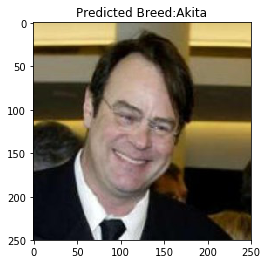

-------------------------------------



File Name: /data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg
--------------------------------------------------------
55
It looks like we have a Human here! And your resembling dog breed is: Dachshund


-------------------------------------



File Name: /data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg
--------------------------------------------------------
124
It looks like we have a Human here! And your resembling dog breed is: Portuguese water dog


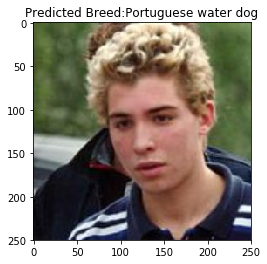

-------------------------------------



File Name: /data/lfw/Donald_Carty/Donald_Carty_0001.jpg
--------------------------------------------------------
3
It looks like we have a Human here! And your resembling dog breed is: Akita


-------------------------------------



File Name: /data/lfw/Barry_Switzer/Barry_Switzer_0001.jpg
--------------------------------------------------------
129
It looks like we have a Human here! And your resembling dog breed is: Welsh springer spaniel


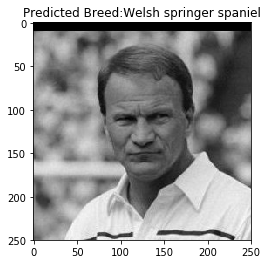

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
--------------------------------------------------------
102
It looks like we have a Dog here! And your predicted breed is: Mastiff


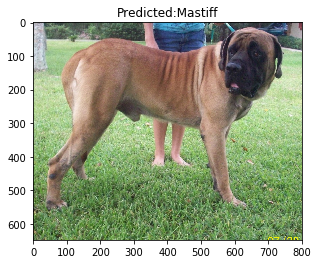

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06826.jpg
--------------------------------------------------------
40
It looks like we have a Dog here! And your predicted breed is: Bullmastiff


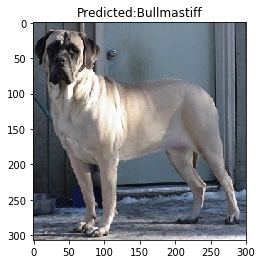

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06871.jpg
--------------------------------------------------------
40
It looks like we have a Dog here! And your predicted breed is: Bullmastiff


-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06812.jpg
--------------------------------------------------------
102
It looks like we have a Dog here! And your predicted breed is: Mastiff


-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06831.jpg
--------------------------------------------------------
102
It looks like we have a Dog here! And your predicted breed is: Mastiff


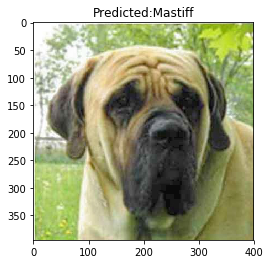

-------------------------------------


In [38]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)




File Name: my_images/wilko_in_shearing.jpg
--------------------------------------------------------
25
It looks like we have a Dog here! And your predicted breed is: Black russian terrier


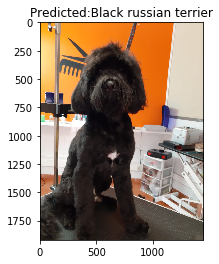

-------------------------------------



File Name: my_images/baby_nacho.jpg
--------------------------------------------------------
46
It looks like we have a Dog here! And your predicted breed is: Chesapeake bay retriever


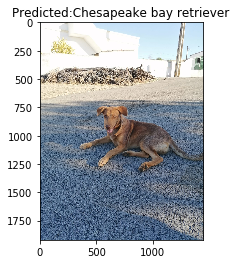

-------------------------------------



File Name: my_images/margarida_tofo.jpeg
--------------------------------------------------------
131
It looks like we have a Human here! And your resembling dog breed is: Xoloitzcuintli


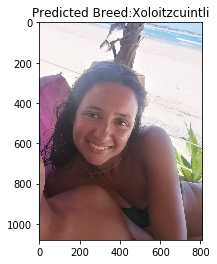

-------------------------------------



File Name: my_images/Goncalo_Mozambique.jpeg
--------------------------------------------------------
131
It looks like we have a Human here! And your resembling dog breed is: Xoloitzcuintli


-------------------------------------



File Name: my_images/elephant_in_south_africa.jpg
--------------------------------------------------------
Error! No Human or Dog has been detected! :( 


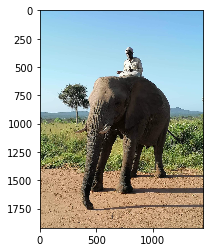

-------------------------------------



File Name: my_images/wilko_at_home.jpg
--------------------------------------------------------
73
It looks like we have a Dog here! And your predicted breed is: Giant schnauzer


-------------------------------------



File Name: my_images/margarida_in_vietnam.jpg
--------------------------------------------------------
38
It looks like we have a Human here! And your resembling dog breed is: Bull terrier


-------------------------------------



File Name: my_images/nuno_south_africa.jpeg
--------------------------------------------------------
105
It looks like we have a Human here! And your resembling dog breed is: Newfoundland


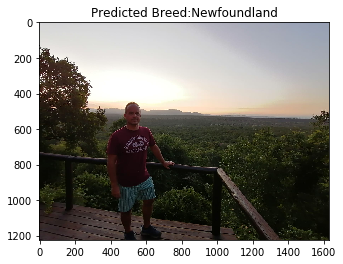

-------------------------------------



File Name: my_images/Basaruto.jpeg
--------------------------------------------------------
Error! No Human or Dog has been detected! :( 


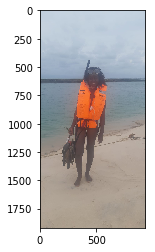

-------------------------------------



File Name: my_images/ricardo_tofo.jpeg
--------------------------------------------------------
131
It looks like we have a Human here! And your resembling dog breed is: Xoloitzcuintli


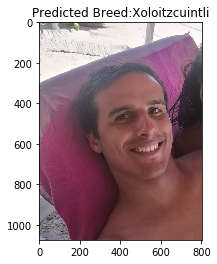

-------------------------------------



File Name: my_images/ricardo_in_kruger_park.jpg
--------------------------------------------------------
55
It looks like we have a Human here! And your resembling dog breed is: Dachshund


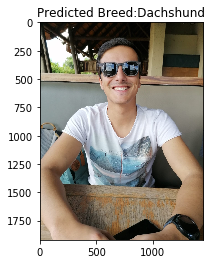

-------------------------------------



File Name: my_images/margarida_in_tailand.jpg
--------------------------------------------------------
123
It looks like we have a Human here! And your resembling dog breed is: Poodle


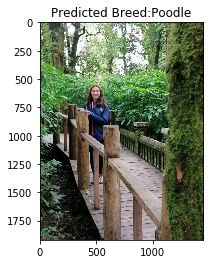

-------------------------------------



File Name: my_images/margarida_surfing.jpg
--------------------------------------------------------
3
It looks like we have a Human here! And your resembling dog breed is: Akita


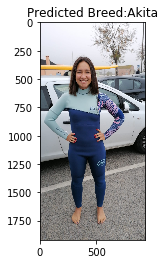

-------------------------------------



File Name: my_images/cow_on_the_road.jpg
--------------------------------------------------------
Error! No Human or Dog has been detected! :( 


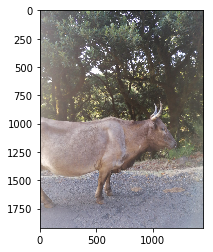

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
--------------------------------------------------------
102
It looks like we have a Dog here! And your predicted breed is: Mastiff


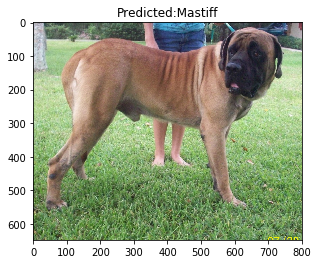

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06826.jpg
--------------------------------------------------------
40
It looks like we have a Dog here! And your predicted breed is: Bullmastiff


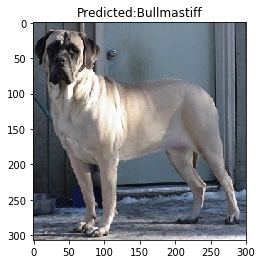

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06871.jpg
--------------------------------------------------------
40
It looks like we have a Dog here! And your predicted breed is: Bullmastiff


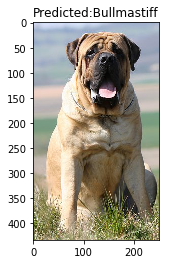

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06812.jpg
--------------------------------------------------------
102
It looks like we have a Dog here! And your predicted breed is: Mastiff


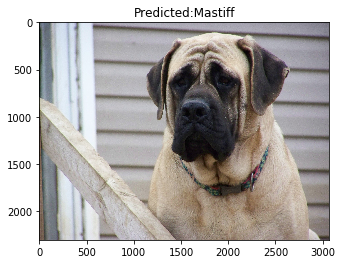

-------------------------------------



File Name: /data/dog_images/train/103.Mastiff/Mastiff_06831.jpg
--------------------------------------------------------
102
It looks like we have a Dog here! And your predicted breed is: Mastiff


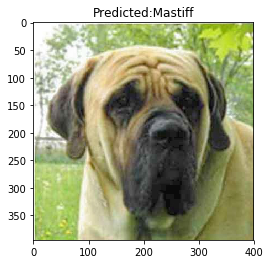

-------------------------------------


In [39]:
my_images_files = np.array(glob("my_images/*"))

## suggested code, below
for file in np.hstack((my_images_files, dog_files[:5])):
    run_app(file)

In [40]:
len(my_images_files)

14